# Base Model

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.nn as nn

from sklearn.model_selection import train_test_split

In [4]:
# load normalized data
path_years_norm = "/content/drive/MyDrive/FinalProject/sPINN/data/df_years_norm.csv"
path_days_norm  = "/content/drive/MyDrive/FinalProject/sPINN/data/df_days_norm.csv"

df_years_norm = pd.read_csv(path_years_norm)
df_days_norm  = pd.read_csv(path_days_norm)

In [5]:
# make sliding window dataset
def make_sliding_window(df, window_size, steps_ahead, target_col):
    # get features (everything except target)
    feature_cols = [c for c in df.columns if c != target_col]
    features = df[feature_cols].values.astype(float)

    # target values
    y_full = df[target_col].values.astype(float)

    X_list = []
    y_list = []

    # build sliding windows
    for i in range(len(features) - window_size - steps_ahead):
        window = features[i:i+window_size]
        target = y_full[i + window_size + steps_ahead]

        X_list.append(window)
        y_list.append(target)

    X = np.array(X_list)
    y = np.array(y_list)

    return X, y


In [6]:
# years sliding window
window_size = 48
steps_ahead = 48 * 3   # 3 days ahead

X_years, y_years = make_sliding_window(
    df_years_norm,
    window_size,
    steps_ahead,
    target_col="WVHT"
)

In [7]:
# days sliding window
window_size = 12
steps_ahead = 48 * 3   # 3 days ahead

X_days, y_days = make_sliding_window(
    df_days_norm,
    window_size,
    steps_ahead,
    target_col="WVHT"
)

In [8]:
# plot the first window of a dataset
def plot_first_window(df, window_size, title_name):
    # get feature cols
    feature_cols = [c for c in df.columns]
    features = df[feature_cols].values.astype(float)

    # first window
    first_window = features[:window_size]

    # flip for plotting
    first_window_flipped = first_window.T

    # plot window
    plt.figure(figsize=(10, 6))
    plt.imshow(first_window_flipped, aspect="auto", cmap="viridis")
    plt.title(f"{title_name} Window ({first_window_flipped.shape[0]} features × {first_window_flipped.shape[1]} time steps)")
    plt.xlabel("Time Steps")
    plt.ylabel("Features")
    plt.colorbar()
    plt.show()


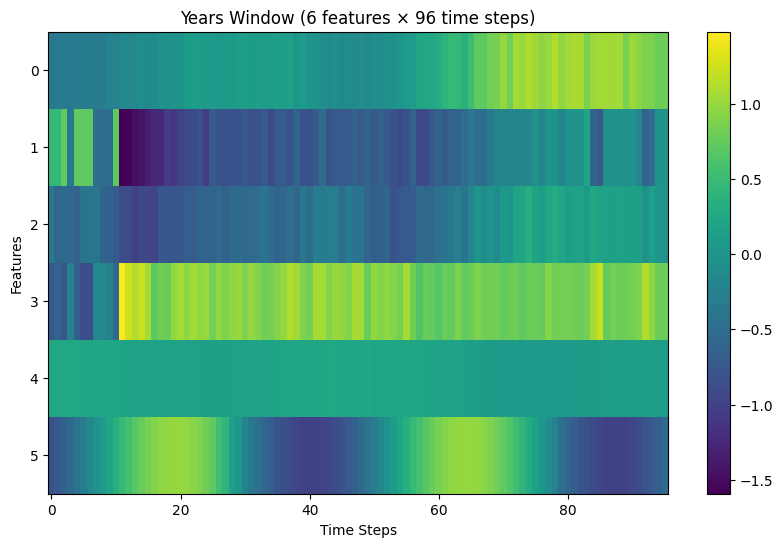

In [9]:
plot_first_window(df_years_norm, window_size=96, title_name="Years")

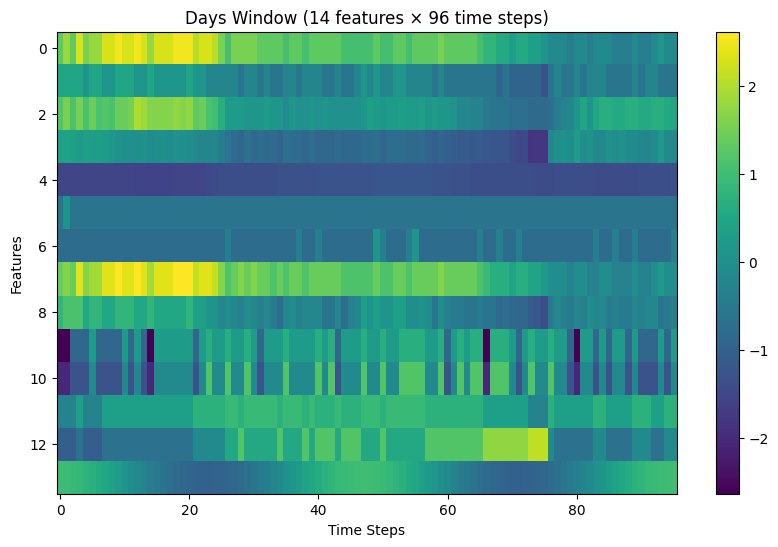

In [10]:
plot_first_window(df_days_norm, window_size=96, title_name="Days")


# PINN-RNN

In [11]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from typing import Tuple, Dict, List

In [12]:
def make_sliding_window(
    df_norm,
    window_size: int,
    steps_ahead: int,
    target_col: str = "WVHT"
) -> Tuple[np.ndarray, np.ndarray]:
    if len(df_norm) < window_size + steps_ahead + 1:
        raise ValueError(
            f"Dataframe too short: {len(df_norm)} vs required {window_size + steps_ahead + 1}"
        )

    features = df_norm.to_numpy().astype(np.float32)
    target   = df_norm[target_col].to_numpy().astype(np.float32)

    num_windows = len(df_norm) - window_size - steps_ahead
    X = np.zeros((num_windows, window_size, features.shape[1]), dtype=np.float32)
    y = np.zeros(num_windows, dtype=np.float32)

    for i in range(num_windows):
        X[i] = features[i:i+window_size]
        y[i] = target[i+window_size+steps_ahead]

    return X, y

In [13]:
def make_pinn_targets(
    df_norm,
    window_size: int,
    steps_ahead: int
) -> np.ndarray:
    if "WVHT" not in df_norm.columns or "DPD" not in df_norm.columns:
        raise ValueError("Missing required columns: WVHT and/or DPD")

    Hs = df_norm["WVHT"].to_numpy().astype(np.float32)
    Tp = df_norm["DPD"].to_numpy().astype(np.float32)

    num_windows = len(df_norm) - window_size - steps_ahead
    Y = np.zeros((num_windows, 2), dtype=np.float32)

    for i in range(num_windows):
        idx = i + window_size + steps_ahead
        Y[i, 0] = Hs[idx]
        Y[i, 1] = Tp[idx]

    return Y

In [14]:
class ImprovedWavePINN(nn.Module):
    def __init__(
        self,
        input_dim: int,
        hidden_dim: int = 128,
        num_layers: int = 3,
        output_dim: int = 2,
        dropout: float = 0.3
    ):
        super().__init__()

        self.lstm = nn.LSTM(
            input_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
            bidirectional=True
        )

        self.attention = nn.Linear(hidden_dim * 2, 1)

        self.fc = nn.Sequential(
            nn.Linear(hidden_dim * 2, 128),
            nn.LayerNorm(128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(dropout * 0.5),
            nn.Linear(64, output_dim)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (B, T, F)
        lstm_out, _ = self.lstm(x)             # (B, T, 2H)
        attn_weights = torch.softmax(self.attention(lstm_out), dim=1)  # (B, T, 1)
        context = torch.sum(attn_weights * lstm_out, dim=1)            # (B, 2H)
        return self.fc(context)               # (B, output_dim)


In [15]:
def physics_wave_action(pred: torch.Tensor) -> torch.Tensor:
    """
    pred: (B, 2) → [Hs, Tp]
    """
    device = pred.device
    dtype  = pred.dtype

    Hs = pred[:, 0]
    Tp = pred[:, 1]

    Tp_safe = Tp.clamp(min=1e-3)

    # wave action N ~ Hs^2 / Tp
    N = (Hs**2) / Tp_safe

    if N.shape[0] > 1:
        dN = N[1:] - N[:-1]
        action_loss = torch.mean(dN**2)
    else:
        action_loss = torch.tensor(0.0, device=device, dtype=dtype)

    # constraints
    period_constraint = torch.mean(torch.relu(-Tp + 0.5))  # Tp > 0.5
    height_constraint = torch.mean(torch.relu(-Hs))        # Hs >= 0

    steepness = Hs / Tp_safe
    steepness_loss = torch.mean(torch.relu(steepness - 0.5))

    total_phys = (
        action_loss +
        0.1 * period_constraint +
        0.1 * height_constraint +
        0.05 * steepness_loss
    )

    return total_phys

In [16]:
class EarlyStopping:
    def __init__(self, patience: int = 15, min_delta: float = 1e-5):
        self.patience   = patience
        self.min_delta  = min_delta
        self.counter    = 0
        self.best_loss  = None
        self.early_stop = False

    def __call__(self, val_loss: float) -> bool:
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter   = 0
        return self.early_stop


In [17]:
def train_pinn_advanced(
    model: nn.Module,
    X_train: torch.Tensor,
    Y_train: torch.Tensor,
    X_val: torch.Tensor,
    Y_val: torch.Tensor,
    epochs_stage1: int = 150,
    epochs_stage2: int = 250,
    lambda_phys: float = 1e-3,
    lr: float = 1e-3,
    patience: int = 20
) -> Dict[str, List[float]]:

    mse = nn.MSELoss()
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        opt, mode='min', factor=0.5, patience=10
    )

    early_stopping = EarlyStopping(patience=patience)

    history: Dict[str, List[float]] = {
        'total': [], 'data': [], 'phys': [], 'val': [],
        'grad_norm': [], 'lr': []
    }

    best_val_loss    = float('inf')
    best_model_state = None

    print("\n" + "="*60)
    print("STAGE 1: Data-Only Training")
    print("="*60)

    # --------------- STAGE 1 ---------------
    for epoch in range(epochs_stage1):
        model.train()
        opt.zero_grad()

        pred = model(X_train)
        data_loss = mse(pred, Y_train)

        data_loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        opt.step()

        model.eval()
        with torch.no_grad():
            val_pred = model(X_val)
            val_loss = mse(val_pred, Y_val).item()

        scheduler.step(val_loss)

        history['total'].append(data_loss.item())
        history['data'].append(data_loss.item())
        history['phys'].append(0.0)
        history['val'].append(val_loss)
        history['grad_norm'].append(float(grad_norm))
        history['lr'].append(opt.param_groups[0]['lr'])

        if val_loss < best_val_loss:
            best_val_loss    = val_loss
            best_model_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

        if epoch % 20 == 0:
            print(
                f"Epoch {epoch:3d} | "
                f"Train: {data_loss.item():.5f} | "
                f"Val: {val_loss:.5f} | "
                f"Grad: {float(grad_norm):.3f} | "
                f"LR: {opt.param_groups[0]['lr']:.2e}"
            )

        if early_stopping(val_loss):
            print(f"Early stopping (Stage 1) at epoch {epoch}")
            break

    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    print("\n" + "="*60)
    print("STAGE 2: Physics-Informed Training")
    print("="*60)

    # --------------- STAGE 2 ---------------
    opt = torch.optim.AdamW(model.parameters(), lr=lr*0.5, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        opt, mode='min', factor=0.5, patience=10
    )
    early_stopping = EarlyStopping(patience=patience)

    for epoch in range(epochs_stage2):
        model.train()
        opt.zero_grad()

        pred = model(X_train)
        data_loss = mse(pred, Y_train)
        phys_loss = physics_wave_action(pred)

        total_loss = data_loss + lambda_phys * phys_loss

        total_loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        opt.step()

        model.eval()
        with torch.no_grad():
            val_pred = model(X_val)
            val_loss = mse(val_pred, Y_val).item()

        scheduler.step(val_loss)

        history['total'].append(total_loss.item())
        history['data'].append(data_loss.item())
        history['phys'].append(phys_loss.item())
        history['val'].append(val_loss)
        history['grad_norm'].append(float(grad_norm))
        history['lr'].append(opt.param_groups[0]['lr'])

        if val_loss < best_val_loss:
            best_val_loss    = val_loss
            best_model_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

        if epoch % 20 == 0:
            print(
                f"Epoch {epoch:3d} | "
                f"Total: {total_loss.item():.5f} | "
                f"Data: {data_loss.item():.5f} | "
                f"Phys: {phys_loss.item():.5f} | "
                f"Val: {val_loss:.5f} | "
                f"Grad: {float(grad_norm):.3f}"
            )

        if early_stopping(val_loss):
            print(f"Early stopping (Stage 2) at epoch {epoch}")
            break

    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"\nBest val loss: {best_val_loss:.5f}")

    return history

In [18]:
def plot_training_history(history: Dict[str, List[float]], save_path: str = None):
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # Data vs Val
    axes[0, 0].plot(history['data'], label='Train', alpha=0.7)
    axes[0, 0].plot(history['val'],  label='Val',   alpha=0.7)
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Data Loss')
    axes[0, 0].legend()
    axes[0, 0].set_yscale('log')
    axes[0, 0].grid(True, alpha=0.3)

    # Physics loss
    axes[0, 1].plot(history['phys'], color='red', alpha=0.7)
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Physics Loss')
    axes[0, 1].set_title('Physics Constraint')
    axes[0, 1].grid(True, alpha=0.3)

    # Gradient norm
    axes[1, 0].plot(history['grad_norm'], color='green', alpha=0.7)
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Gradient Norm')
    axes[1, 0].set_title('Gradient Monitoring')
    axes[1, 0].grid(True, alpha=0.3)

    # Learning rate
    axes[1, 1].plot(history['lr'], color='purple', alpha=0.7)
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('LR')
    axes[1, 1].set_title('Learning Rate')
    axes[1, 1].set_yscale('log')
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()

In [19]:
def run_and_plot(df_norm, label, window_size=48, steps_ahead=48*3):
    print(f"\n==================== {label.upper()} ====================")

    # windows
    X, _ = make_sliding_window(df_norm, window_size, steps_ahead)
    Y    = make_pinn_targets(df_norm, window_size, steps_ahead)
    print(f"{label} → X={X.shape}, Y={Y.shape}")

    # split
    X_train, X_val, Y_train, Y_val = train_test_split(
        X, Y, test_size=0.2, shuffle=False
    )

    X_train_t = torch.tensor(X_train, dtype=torch.float32)
    Y_train_t = torch.tensor(Y_train, dtype=torch.float32)
    X_val_t   = torch.tensor(X_val,   dtype=torch.float32)
    Y_val_t   = torch.tensor(Y_val,   dtype=torch.float32)

    # model
    model = ImprovedWavePINN(
        input_dim=X_train.shape[2],
        hidden_dim=128,
        num_layers=3,
        dropout=0.3
    )
    print(f"Params: {sum(p.numel() for p in model.parameters()):,}")

    # train
    history = train_pinn_advanced(
        model,
        X_train_t, Y_train_t,
        X_val_t,   Y_val_t,
        epochs_stage1=100,
        epochs_stage2=150,
        lambda_phys=1e-3,
        lr=1e-3,
        patience=20
    )

    # save model
    torch.save(model.state_dict(), f"pinn_{label}.pt")
    print(f"Saved model: pinn_{label}.pt")

    # loss plots
    plot_training_history(history, save_path=f"loss_{label}.png")
    print(f"Saved loss plot: loss_{label}.png")

    # prediction vs real
    model.eval()
    with torch.no_grad():
        preds = model(X_val_t).cpu().numpy()

    real = Y_val_t.cpu().numpy()
    pred_hs = preds[:, 0]
    real_hs = real[:, 0]

    plt.figure(figsize=(14,4))
    plt.plot(real_hs, label="Real Hs", linewidth=2)
    plt.plot(pred_hs, label=f"Predicted Hs ({label})", linestyle="--")
    plt.title(f"Validation Prediction Comparison — {label}")
    plt.xlabel("Time Index")
    plt.ylabel("Hs (normalized)")
    plt.legend()
    plt.grid(True)
    plt.savefig(f"pred_compare_{label}.png", dpi=150, bbox_inches='tight')
    plt.show()
    print(f"Saved prediction comparison: pred_compare_{label}.png")

    return history, preds, real


===== TRAINING BASELINE RNN =====
[BASE] Epoch   0 | train=1.008274 | val_mse=1.103109
[BASE] Epoch  40 | train=0.693350 | val_mse=1.256533
[BASE] Epoch  80 | train=0.520947 | val_mse=2.042613
[BASE] Epoch 120 | train=0.346018 | val_mse=2.259219
[BASE] Epoch 160 | train=0.243667 | val_mse=2.355658
[BASE] Epoch 200 | train=0.192134 | val_mse=2.340344
[BASE] Epoch 240 | train=0.158364 | val_mse=2.318959
[BASE] Epoch 280 | train=0.132829 | val_mse=2.320426
[BASE] Epoch 320 | train=0.113104 | val_mse=2.359819
[BASE] Epoch 360 | train=0.096787 | val_mse=2.407080
[BASE] Epoch 400 | train=0.083573 | val_mse=2.447107
[BASE] Epoch 440 | train=0.072899 | val_mse=2.470329
[BASE] Epoch 480 | train=0.064375 | val_mse=2.490411
[BASE] Epoch 520 | train=0.057049 | val_mse=2.502043
[BASE] Epoch 560 | train=0.050729 | val_mse=2.510257
[BASE] Epoch 600 | train=0.045636 | val_mse=2.522505
[BASE] Epoch 640 | train=0.040916 | val_mse=2.529300
[BASE] Epoch 680 | train=0.037105 | val_mse=2.546741
[BASE] Epoc

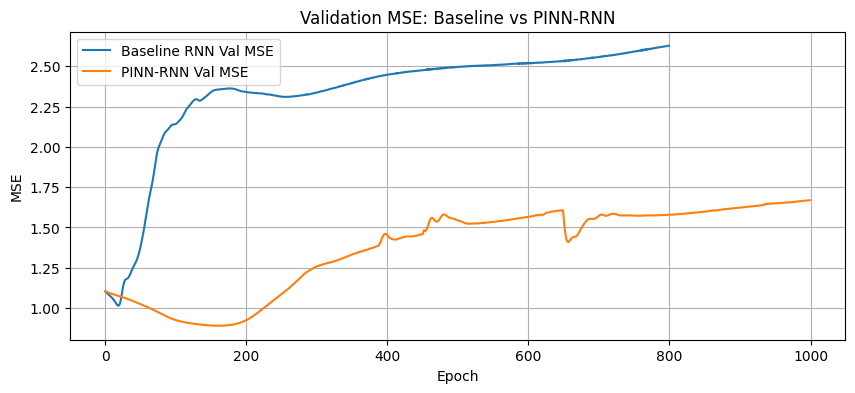

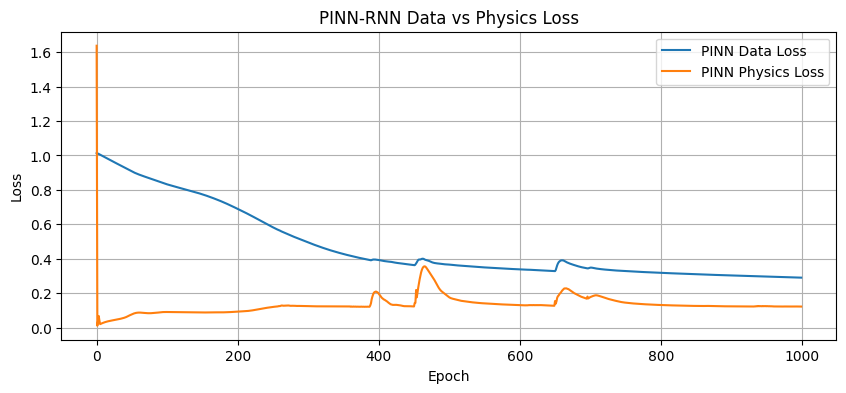

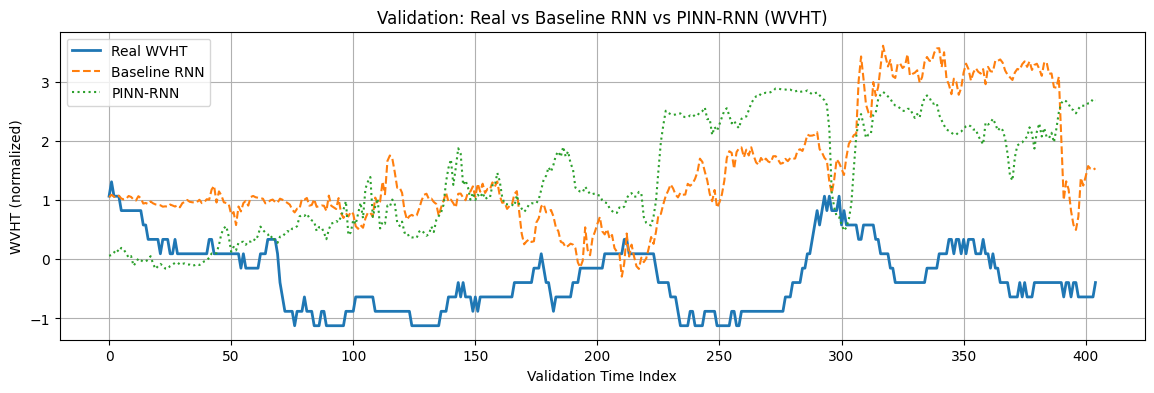

In [35]:
# Sliding window
window_size = 7
steps_ahead = 48 * 3  # 3 days ahead

feature_cols = [c for c in df_days_norm.columns if c != "datetime"]
target_cols  = [c for c in feature_cols if c != "time_sin"]  # 13 targets

features        = df_days_norm[feature_cols].values.astype(float)       # (T, 14)
features_target = df_days_norm[target_cols].values.astype(float)       # (T, 13)

X_list, Y_list = [], []
for i in range(len(features) - window_size - steps_ahead):
    X_list.append(features[i:i+window_size])                      # (7,14)
    Y_list.append(features_target[i+window_size+steps_ahead])     # (13,)

X = np.array(X_list)  # (N, 7, 14)
Y = np.array(Y_list)  # (N, 13)

# Train/Val split
X_train, X_val, Y_train, Y_val = train_test_split(
    X, Y, test_size=0.2, shuffle=False
)

# Torch tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
Y_train_t = torch.tensor(Y_train, dtype=torch.float32)
X_val_t   = torch.tensor(X_val,   dtype=torch.float32)
Y_val_t   = torch.tensor(Y_val,   dtype=torch.float32)

# Index helpers
WVHT_IDX = target_cols.index("WVHT")
SWH_IDX  = target_cols.index("SwH")
WWH_IDX  = target_cols.index("WWH")
DPD_IDX  = target_cols.index("DPD")


# Wave model
class WaveLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc   = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, (h, c) = self.lstm(x)
        return self.fc(h[-1])  # shape (B, 13)

input_dim  = X_train.shape[2]   # 14
hidden_dim = 128
output_dim = Y_train.shape[1]   # 13

mse = nn.MSELoss()


# physics loss
def physics_loss_real(pred):
    """
    pred: (N, 13)
    Implements real wave physics using WVHT, SwH, WWH, DPD.
    """

    Hs  = pred[:, WVHT_IDX]     # significant wave height
    Hsw = pred[:, SWH_IDX]      # swell height
    Hww = pred[:, WWH_IDX]      # wind wave height
    T   = pred[:, DPD_IDX]      # dominant period

    eps = 1e-4

    # 1) Energy relation (Hs^2 ~ Hsw^2 + Hww^2)
    L1 = (Hs**2 - (Hsw**2 + Hww**2))**2

    # 2) Breaking steepness constraint: Hs / T^2 <= k
    steep = Hs / (T**2 + eps)
    k = 0.15
    L2 = torch.clamp(steep - k, min=0.0)**2

    # 3) Physical non-negativity
    L3 = (
        torch.clamp(-Hs,  min=0.0)**2 +
        torch.clamp(-Hsw, min=0.0)**2 +
        torch.clamp(-Hww, min=0.0)**2 +
        torch.clamp(-T,   min=0.0)**2
    )

    return torch.mean(L1 + L2 + L3)



# base rnn
baseline_rnn = WaveLSTM(input_dim, hidden_dim, output_dim)
opt_base = torch.optim.Adam(baseline_rnn.parameters(), lr=1e-3)

epochs = 800
base_train_loss = []
base_val_mse    = []
print("\n===== TRAINING BASELINE RNN =====")
for epoch in range(epochs):
    baseline_rnn.train()
    opt_base.zero_grad()

    pred_train = baseline_rnn(X_train_t)
    loss_train = mse(pred_train, Y_train_t)
    loss_train.backward()
    opt_base.step()

    baseline_rnn.eval()
    with torch.no_grad():
        pred_val = baseline_rnn(X_val_t)
        val_mse  = mse(pred_val, Y_val_t).item()

    base_train_loss.append(loss_train.item())
    base_val_mse.append(val_mse)

    if epoch % 40 == 0:
        print(f"[BASE] Epoch {epoch:3d} | train={loss_train.item():.6f} | val_mse={val_mse:.6f}")


# pinn rnn
pinn_rnn = WaveLSTM(input_dim, hidden_dim, output_dim)
opt_pinn = torch.optim.Adam(pinn_rnn.parameters(), lr=1e-3)

lambda_phys = 0.2
pinn_train_total = []
pinn_train_data  = []
pinn_train_phys  = []
pinn_val_mse     = []

print("\n===== TRAINING PINN-RNN =====")

epochs = 1000

for epoch in range(epochs):
    pinn_rnn.train()
    opt_pinn.zero_grad()

    pred_train = pinn_rnn(X_train_t)  # (N,13)

    data_loss  = mse(pred_train, Y_train_t)
    phys_loss  = physics_loss_real(pred_train)

    total_loss = data_loss + lambda_phys * phys_loss
    total_loss.backward()
    opt_pinn.step()

    # validation (data only)
    pinn_rnn.eval()
    with torch.no_grad():
        pred_val = pinn_rnn(X_val_t)
        val_mse  = mse(pred_val, Y_val_t).item()

    pinn_train_total.append(total_loss.item())
    pinn_train_data.append(data_loss.item())
    pinn_train_phys.append(phys_loss.item())
    pinn_val_mse.append(val_mse)

    if epoch % 40 == 0:
        print(
            f"[PINN] Epoch {epoch:3d} | total={total_loss.item():.6f} "
            f"| data={data_loss.item():.6f} "
            f"| phys={phys_loss.item():.6f} "
            f"| val_mse={val_mse:.6f}"
        )


# loss plots
plt.figure(figsize=(10,4))
plt.plot(base_val_mse, label="Baseline RNN Val MSE")
plt.plot(pinn_val_mse, label="PINN-RNN Val MSE")
plt.title("Validation MSE: Baseline vs PINN-RNN")
plt.xlabel("Epoch"); plt.ylabel("MSE")
plt.grid(True); plt.legend()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(pinn_train_data, label="PINN Data Loss")
plt.plot(pinn_train_phys, label="PINN Physics Loss")
plt.title("PINN-RNN Data vs Physics Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.grid(True); plt.legend()
plt.show()


# wave plot
baseline_rnn.eval()
pinn_rnn.eval()

with torch.no_grad():
    base_val_pred = baseline_rnn(X_val_t).cpu().numpy()
    pinn_val_pred = pinn_rnn(X_val_t).cpu().numpy()
    real_val      = Y_val_t.cpu().numpy()

real_wvht = real_val[:, WVHT_IDX]
base_wvht = base_val_pred[:, WVHT_IDX]
pinn_wvht = pinn_val_pred[:, WVHT_IDX]

plt.figure(figsize=(14,4))
plt.plot(real_wvht, label="Real WVHT", linewidth=2)
plt.plot(base_wvht, label="Baseline RNN", linestyle="--")
plt.plot(pinn_wvht, label="PINN-RNN", linestyle=":")
plt.title("Validation: Real vs Baseline RNN vs PINN-RNN (WVHT)")
plt.xlabel("Validation Time Index")
plt.ylabel("WVHT (normalized)")
plt.grid(True); plt.legend()
plt.show()
